In [1]:
!pip3 install torch 
!pip3 install tqdm
!pip3 install unidecode
!pip3 install torchvision

In [0]:
import torch
import torchvision
from torchvision import transforms
from torchvision import utils
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm

import unidecode
import string
import random
import re
from torch.autograd import Variable
import pdb
import os

### Import the Data

In [3]:
!wget --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&confirm='"$(wget --save-cookies cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')"'&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM' -O img_align_celeba.zip
!unzip -q img_align_celeba
!mkdir test
!mv img_align_celeba test

--2018-11-05 19:48:02--  https://docs.google.com/uc?export=download&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 74.125.124.138, 74.125.124.102, 74.125.124.100, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘STDOUT’

-                       [ <=>                ]   3.16K  --.-KB/s    in 0s      

2018-11-05 19:48:03 (27.7 MB/s) - written to stdout [3238]

--2018-11-05 19:48:03--  https://docs.google.com/uc?export=download&confirm=7Zxb&id=0B7EVK8r0v71pZjFTYXZWM3FlRnM
Resolving docs.google.com (docs.google.com)... 74.125.124.102, 74.125.124.100, 74.125.124.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.124.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-84-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/gjqaeu6uu1ho78p1v7gk

In [0]:
class CelebaDataset(Dataset):
  def __init__(self, root, size=128, train=True):
    super(CelebaDataset, self).__init__()
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((size,size)),transforms.ToTensor()]))
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    return img[0]
 

  def __len__(self):
    return len(self.dataset_folder)

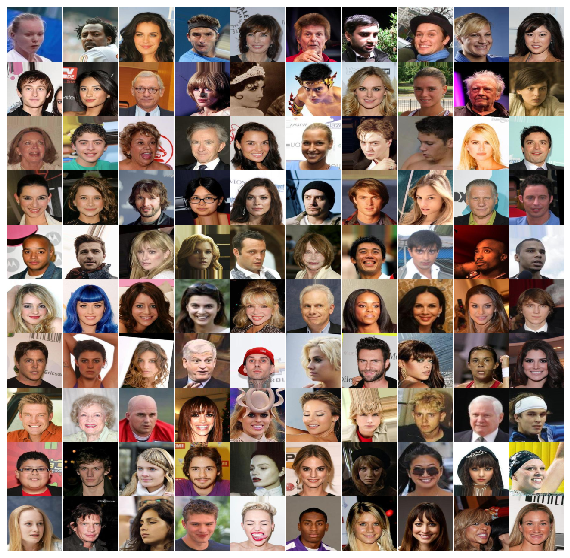

In [5]:
data = CelebaDataset('test')

fig = plt.figure(figsize=(10,10))

for pic in range(1,101):
  ax = plt.subplot(10,10,pic)
  im = data[pic-1 + 20100]
  plt.imshow(im.numpy().transpose(1,2,0))
  
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
fig.subplots_adjust(hspace = 0, wspace = 0)
plt.show()

In [0]:
#Create the discriminator and generator

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.discriminator = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 2, stride = 2),
                                      nn.LeakyReLU(negative_slope = .2),
                                      nn.Conv2d(64, 128, kernel_size = 2, stride = 2),
                                      nn.LeakyReLU(negative_slope = .2),
                                      nn.Conv2d(128, 256, kernel_size = 2, stride = 2),
                                      nn.LeakyReLU(negative_slope = .2),
                                      nn.Conv2d(256, 512, kernel_size = 2, stride = 2),
                                      nn.LeakyReLU(negative_slope = .2),
                                      nn.Conv2d(512,1024,kernel_size = 2, stride = 2))
    
    self.output_val = nn.Linear(1024*4*4, 1) #The size of the discriminator is the size of self.discriminator, or 1024*4*4*batchsize
    
   
  def forward(self,input):
    
    last_layer = self.discriminator(input)
    return(self.output_val(last_layer.view(-1,1024*4*4))) #This passes a vector into the linear layer
  
  
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc_layer = nn.Linear(100, 4*4*1024)
    
    self.generator = nn.Sequential(nn.LeakyReLU(negative_slope = .2),
                                   nn.ConvTranspose2d(1024,512,kernel_size = 2, stride = 2),
                                   nn.LeakyReLU(negative_slope = .2),
                                   nn.ConvTranspose2d(512,256,kernel_size = 2, stride = 2),
                                   nn.LeakyReLU(negative_slope = .2),
                                   nn.ConvTranspose2d(256,128,kernel_size = 2, stride = 2),
                                   nn.LeakyReLU(negative_slope = .2),
                                   nn.ConvTranspose2d(128,64,kernel_size = 2, stride = 2),
                                   nn.LeakyReLU(negative_slope = .2),
                                   nn.ConvTranspose2d(64,3,kernel_size = 2, stride = 2))
    
  def forward(self,input):
    
    fc_all = self.fc_layer(input.squeeze()).view(-1,1024,4,4)#Size of discrimnator and generator match!    
    return self.generator(fc_all)

In [0]:
beta1 = 0.5 # 0
beta2 = 0.999 # 0.9
lamda = 10
ncritic = 1 # 5
learning_rate = 0.0002 # 0.0001
batch_size = 200
epochs = 16
batch_norm_decay=0.9
batch_norm_epsilon=1e-5

epoch:0, genloss:2871.1077, disloss:151730432.000: 100%|██████████| 1013/1013 [28:20<00:00,  1.79s/it]


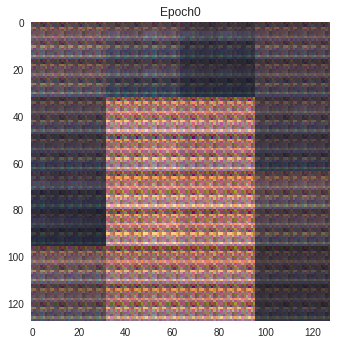

epoch:1, genloss:-317.6085, disloss:43177604.000: 100%|██████████| 1013/1013 [28:22<00:00,  1.75s/it]


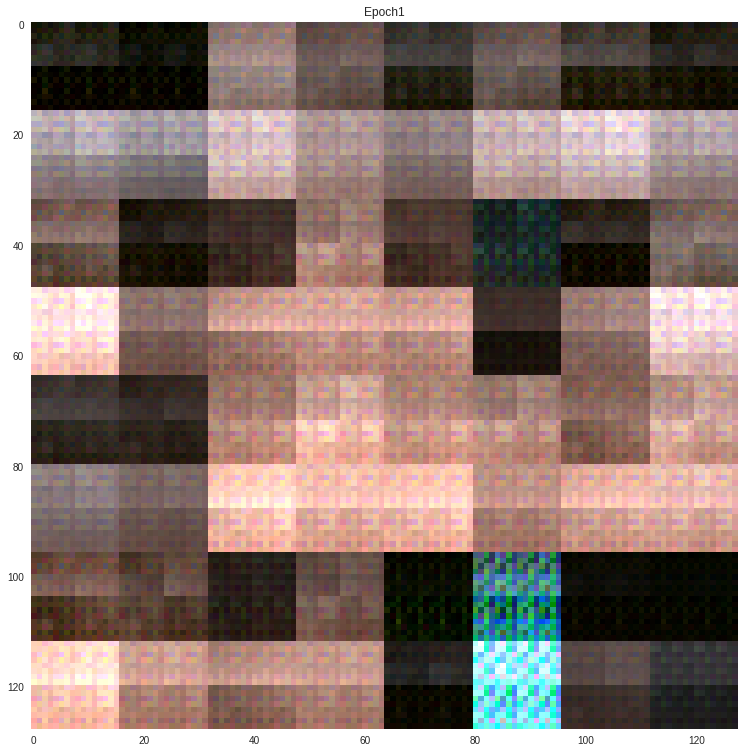

epoch:2, genloss:-19830.3984, disloss:876939648.000: 100%|██████████| 1013/1013 [28:02<00:00,  1.65s/it]


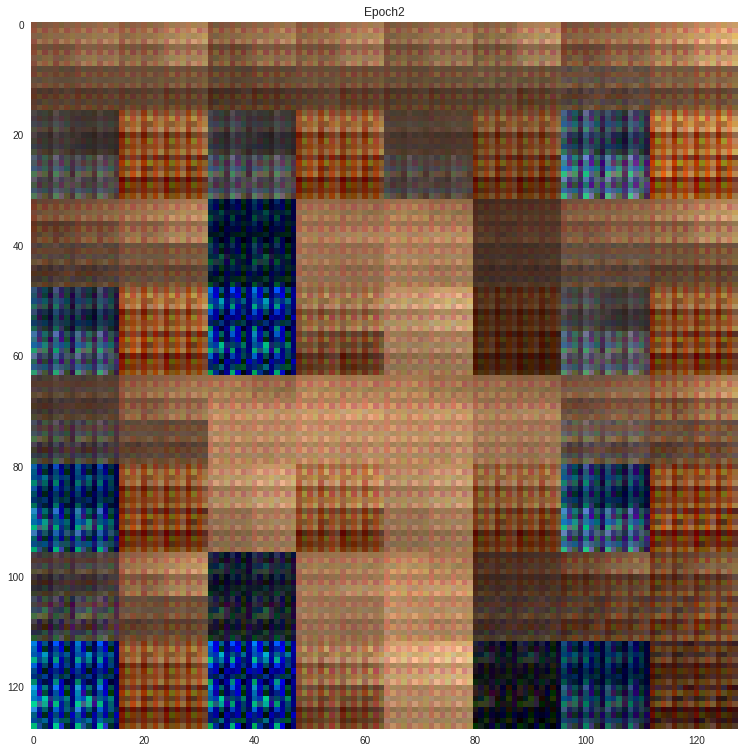

epoch:3, genloss:-34655.1445, disloss:421662144.000: 100%|██████████| 1013/1013 [28:03<00:00,  1.61s/it]


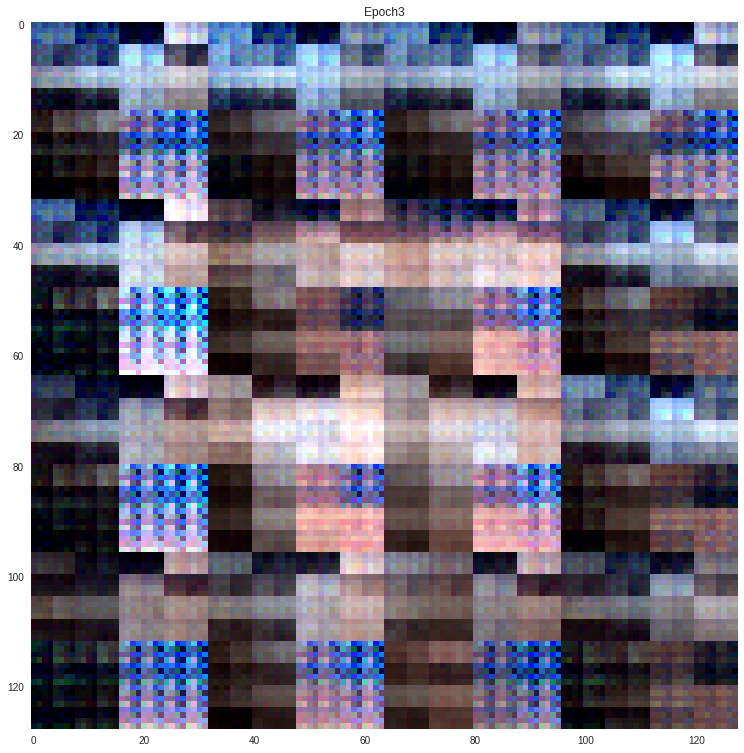

epoch:4, genloss:-2413.5271, disloss:177091712.000: 100%|██████████| 1013/1013 [27:52<00:00,  1.60s/it]


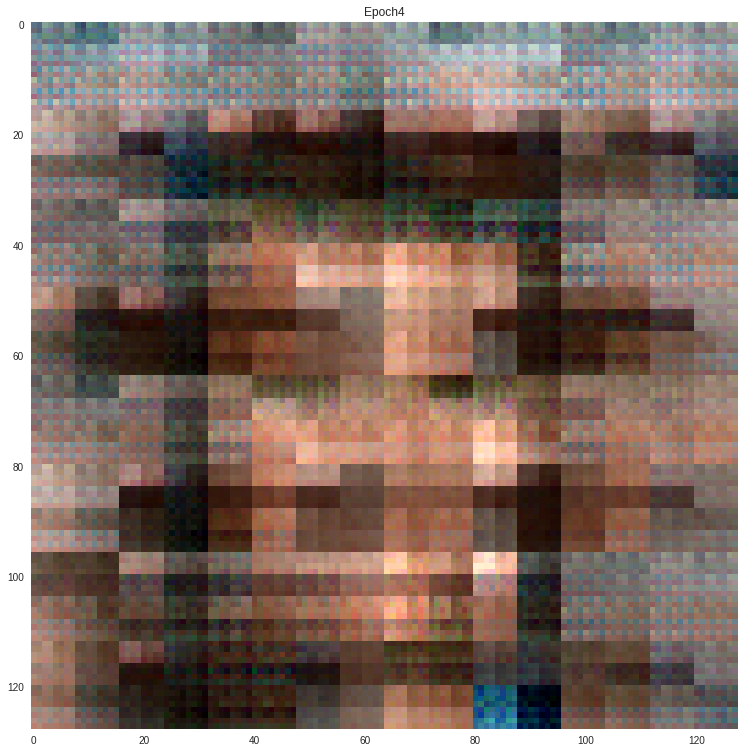

epoch:5, genloss:4321.5762, disloss:167589120.000: 100%|██████████| 1013/1013 [26:50<00:00,  1.59s/it]


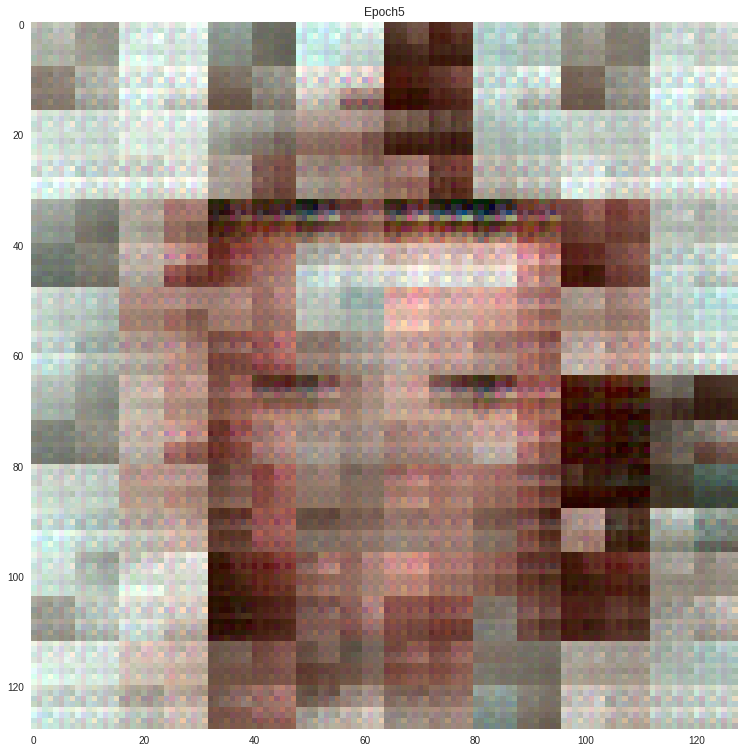

epoch:6, genloss:3068.9033, disloss:28209898.000: 100%|██████████| 1013/1013 [26:48<00:00,  1.57s/it]


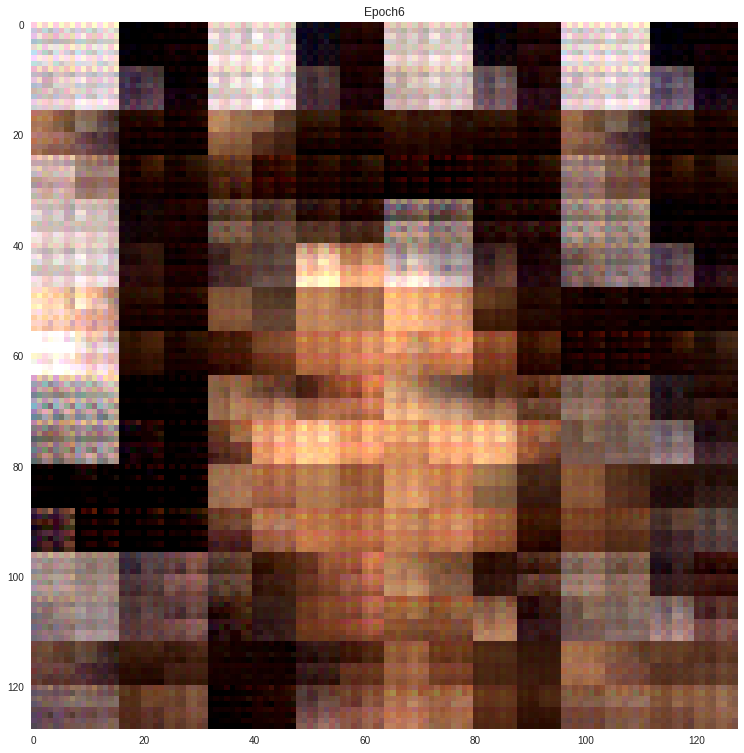

epoch:7, genloss:13641.6924, disloss:474635840.000: 100%|██████████| 1013/1013 [26:40<00:00,  1.57s/it]


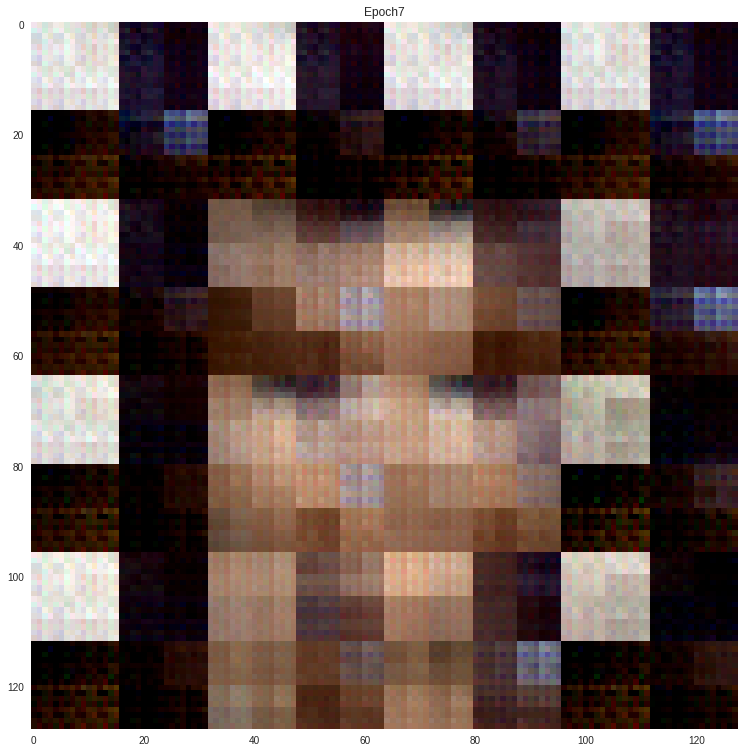

epoch:8, genloss:9026.7363, disloss:838083008.000: 100%|██████████| 1013/1013 [26:50<00:00,  1.59s/it]


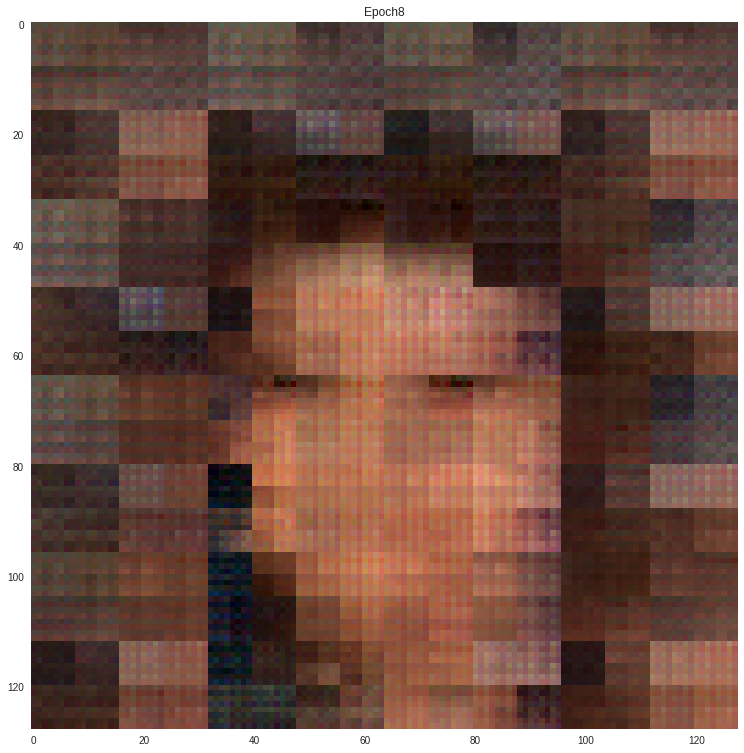

epoch:9, genloss:21739.2441, disloss:970616704.000: 100%|██████████| 1013/1013 [27:09<00:00,  1.61s/it]


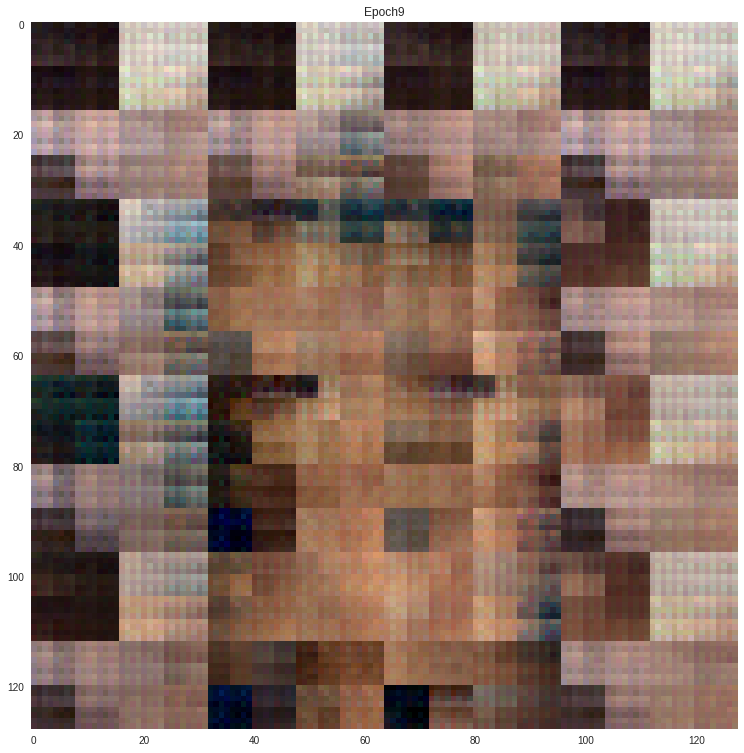

epoch:10, genloss:40663.5664, disloss:2480223488.000: 100%|██████████| 1013/1013 [27:16<00:00,  1.60s/it]


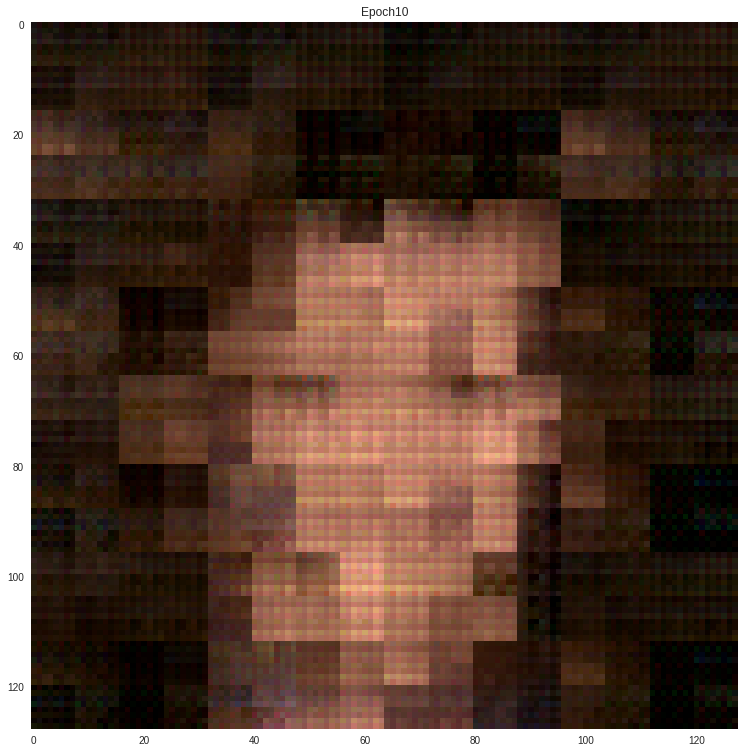

epoch:11, genloss:9760.0996, disloss:3576544256.000: 100%|██████████| 1013/1013 [27:09<00:00,  1.60s/it]


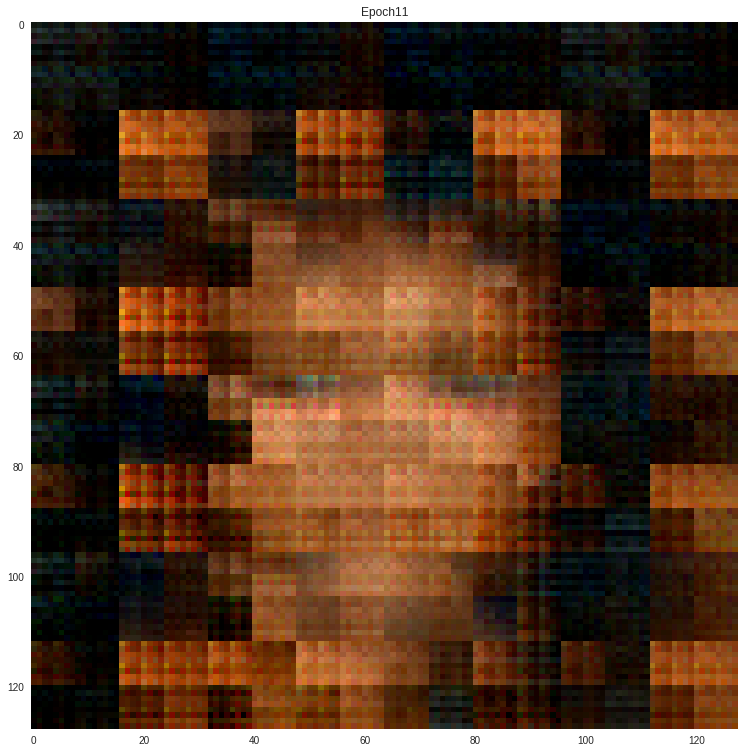

epoch:12, genloss:52168.2812, disloss:6213606400.000: 100%|██████████| 1013/1013 [28:46<00:00,  1.70s/it]


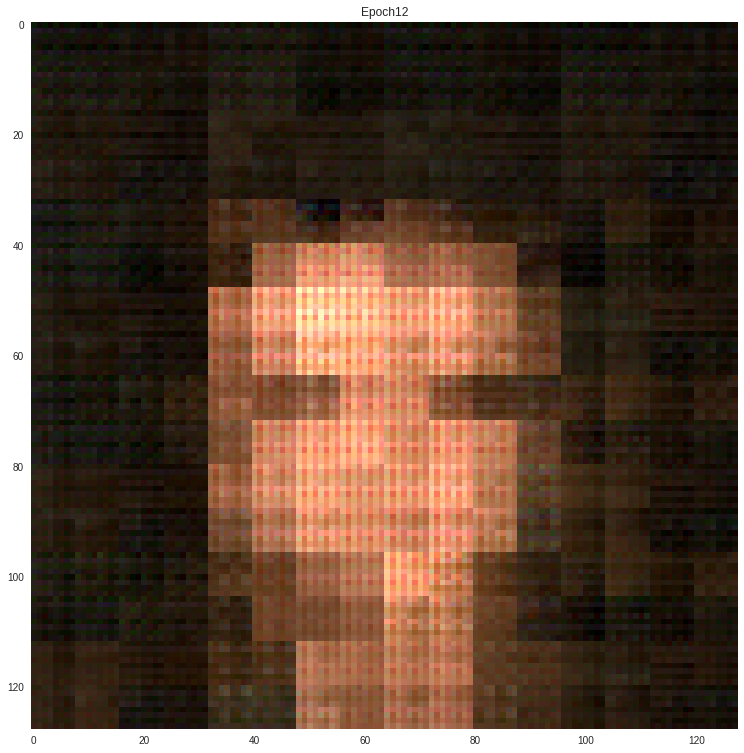

epoch:13, genloss:91494.8828, disloss:31798958080.000: 100%|██████████| 1013/1013 [28:58<00:00,  1.70s/it]


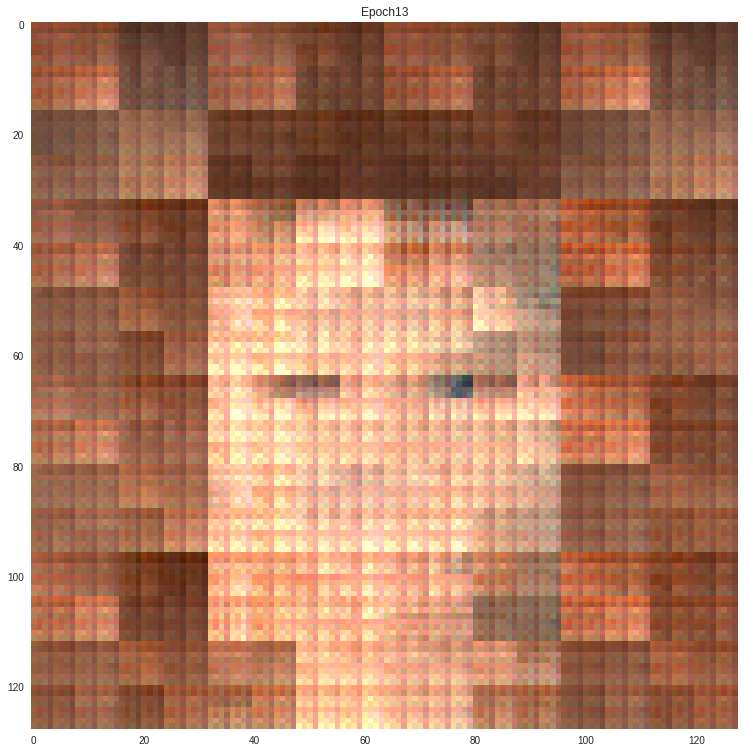

epoch:14, genloss:5978.2114, disloss:7224060416.000: 100%|██████████| 1013/1013 [27:17<00:00,  1.61s/it]


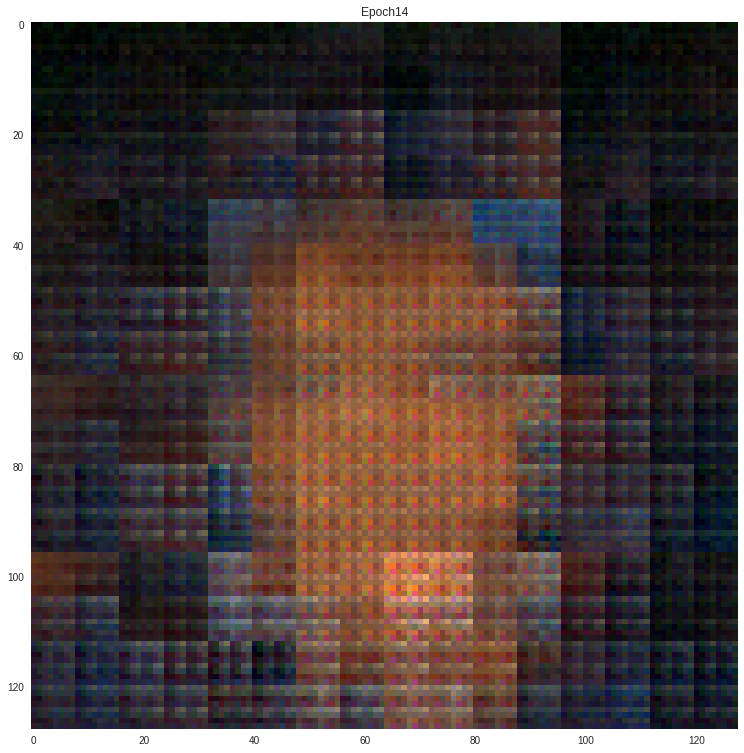

epoch:15, genloss:53858.2188, disloss:18072186880.000: 100%|██████████| 1013/1013 [27:39<00:00,  1.60s/it]


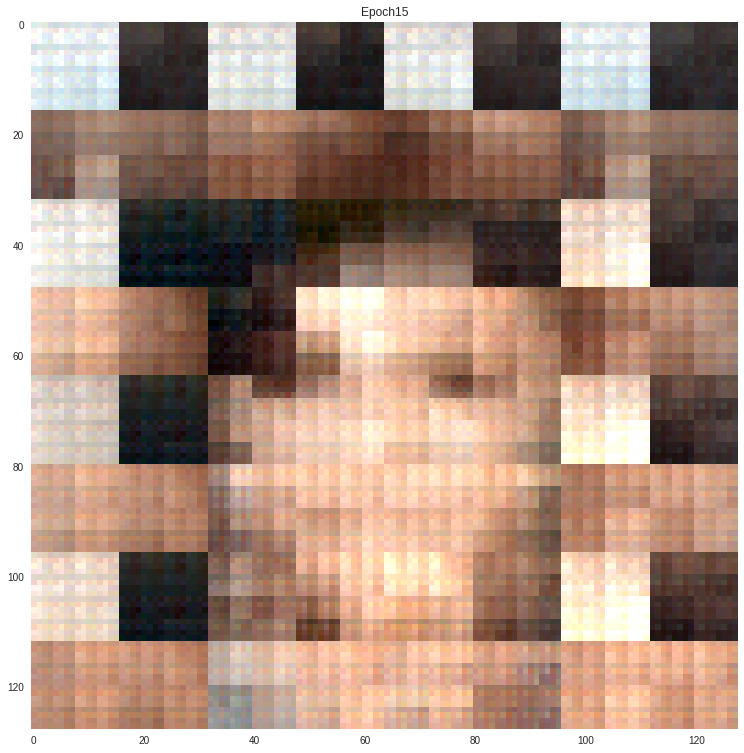

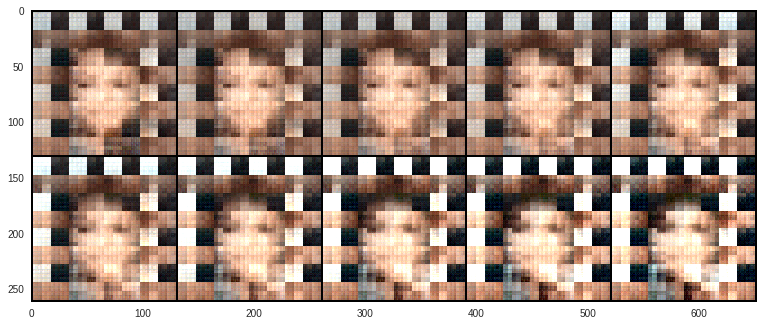

In [8]:
#initialize your generator and discriminator models

gen_model = Generator()
dis_model = Discriminator()

#initialize separate optimizer for both gen and disc

dis_model = dis_model.cuda() #Make sure we use GPU!
d_objectives = torch.nn.MSELoss()  #use this loss function
dis_optim = optim.Adam(dis_model.parameters(), lr = learning_rate, betas = (beta1, beta2)) #use model.parameters() to recursive call list

gen_model = gen_model.cuda()
g_objective = torch.nn.MSELoss()
gen_optim = optim.Adam(gen_model.parameters(), lr = learning_rate, betas = (beta1, beta2))


#initialize your dataset and dataloader
 
trainloader = DataLoader(data, #celebrity faces, parallelizes
                         batch_size = batch_size, 
                         pin_memory = True)  #gives each batch a different location in the GPU

for e in range(epochs):
                         
  loop = tqdm(total = len(trainloader),position = 0)
                         
  for true_img in trainloader:
 
    #train discriminator#
 
    #because you want to be able to backprop through the params in discriminator 
    for p in dis_model.parameters():
      p.requires_grad = True #turns of discriminator
 
    for n in range(ncritic):
      dis_optim.zero_grad()
      x = true_img.cuda()
      batch_size = x.size(0)                   
 
      # generate noise tensor z
      z = torch.randn(size = (batch_size, 100, 1)).cuda() #note that there are 100 features to learn, so the latent variable z = 100
      e_ = torch.randn(size = (batch_size, 1, 1,1)).cuda()
      x_twid = gen_model(z) #gives the generator batch x 3 x 128 x 128
      x_hat = e_*x + (1-e_)*x_twid
                         
      # calculate disc loss: you will need autograd.grad()
      x_hat = autograd.Variable(x_hat, requires_grad = True)
      dis_model(x_hat).sum().backward()
      reg_term = x_hat.grad.view(batch_size, -1).norm(p=2)
      dis_optim.zero_grad()
      L = dis_model(x_twid) - dis_model(x) + lamda *(reg_term -1)**2
                         
      # call dloss.backward() and disc_optim.step()
      loss = L.mean()
      loss.backward()
      dis_optim.step()
                         
      #zero out gradient                   
      dis_optim.zero_grad()
                         
    #train generator#
    for p in dis_model.parameters():
      p.requires_grad = False #turns off discriminator
 
    gen_optim.zero_grad()
 
    # generate noise tensor z
    z = torch.randn(size = (batch_size, 100, 1)).cuda()                     
    # compute generator loss and calculate loss for gen
    g_loss = (-1*dis_model(gen_model(z))).mean()
    # call gloss.backward() and gen_optim.step()
    g_loss.backward()
    gen_optim.step()
    gen_optim.zero_grad()
     
    loop.set_description('epoch:{}, genloss:{:.4f}, disloss:{:.3f}'.format(e, g_loss.item(), loss.item()))
     
    loop.update(1)
  loop.close()
                         
  #To see progress, plot an image every epoch
  generated = gen_model(z)
  clamped = torch.clamp(generated[0], 0 , 1)
  plt.imshow(clamped.cpu().detach().numpy().transpose(1,2,0))
  plt.grid('off')
  plt.title(f'Epoch{e}')
  plt.show()
                         
  #Interpolated images:
  fig = plt.figure(figsize = (13,13))
  imgs = []

  z1 = torch.randn(size = (100,1)).cuda()
  z2 = torch.randn(size = (100,1)).cuda()
  
  
  for i in range(1,11):
    inter_im = torch.lerp(z1,z2, i*.2)
    gen_img = gen_model(inter_im)
    clamped_2 = torch.clamp(gen_img[0], 0 , 1)
    imgs.append(clamped_2.squeeze())
    plt.grid('off')
  
  final_img = utils.make_grid(imgs,5)
  plt.imshow(final_img.detach().permute(1,2,0))
  
 
                         
    

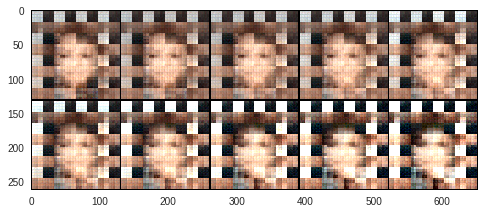

In [9]:
imgs = []
for i in range(1,11):
  inter_im = torch.lerp(z1,z2, i*.2)
  gen_img = gen_model(inter_im)
  clamped_2 = torch.clamp(gen_img[0], 0 , 1)
  imgs.append(clamped_2.squeeze())
  plt.grid('off')
  
final_img = utils.make_grid(imgs,5)
plt.imshow(final_img.detach().permute(1,2,0))